In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from src.data_loader import load_and_preprocess_mnist
from src.models.bernoulli_mixture import BernoulliMixture
from src.visualization import plot_clusters

np.random.seed(42)

## 1. Load Binarized Data

Bernoulli distribution requires binary data (0/1 values).

In [2]:
# Load binarized data
X_train, y_train, X_test, y_test = load_and_preprocess_mnist(
    n_samples=5000,
    binarize=True,  # Binary data for Bernoulli
    flatten=True
)

print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")
print(f"Unique values: {np.unique(X_train)}")

Training data: (5000, 784)
Test data: (10000, 784)
Unique values: [0. 1.]


## 2. Fit Bernoulli Mixture Model

The EM algorithm iteratively refines the model parameters until convergence.

In [3]:
# Initialize and fit model
em_model = BernoulliMixture(n_components=10, max_iters=1000, random_state=42)
em_model.fit(X_train)

print(f"Converged in {em_model.n_iter_} iterations")
print(f"Mixture weights shape: {em_model.mixture_weights_.shape}")
print(f"Component parameters shape: {em_model.components_params_.shape}")
print(f"\nMixture weights (π):")
for k, weight in enumerate(em_model.mixture_weights_):
    print(f"  Component {k}: {weight:.3f} ({weight*100:.1f}%)")

print(f"\nHard cluster assignments:")
unique, counts = np.unique(em_model.labels_, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({count/len(em_model.labels_)*100:.1f}%)")

Converged in 496 iterations
Mixture weights shape: (10,)
Component parameters shape: (10, 784)

Mixture weights (π):
  Component 0: 0.131 (13.1%)
  Component 1: 0.079 (7.9%)
  Component 2: 0.083 (8.3%)
  Component 3: 0.093 (9.3%)
  Component 4: 0.114 (11.4%)
  Component 5: 0.090 (9.0%)
  Component 6: 0.100 (10.0%)
  Component 7: 0.114 (11.4%)
  Component 8: 0.086 (8.6%)
  Component 9: 0.111 (11.1%)

Hard cluster assignments:
  Cluster 0: 656 samples (13.1%)
  Cluster 1: 392 samples (7.8%)
  Cluster 2: 414 samples (8.3%)
  Cluster 3: 465 samples (9.3%)
  Cluster 4: 569 samples (11.4%)
  Cluster 5: 454 samples (9.1%)
  Cluster 6: 500 samples (10.0%)
  Cluster 7: 568 samples (11.4%)
  Cluster 8: 428 samples (8.6%)
  Cluster 9: 554 samples (11.1%)


## 3. Visualize Learned Component Parameters

Each component's $\theta_k$ represents the probability map for that cluster. Brighter pixels = higher probability of being "on".

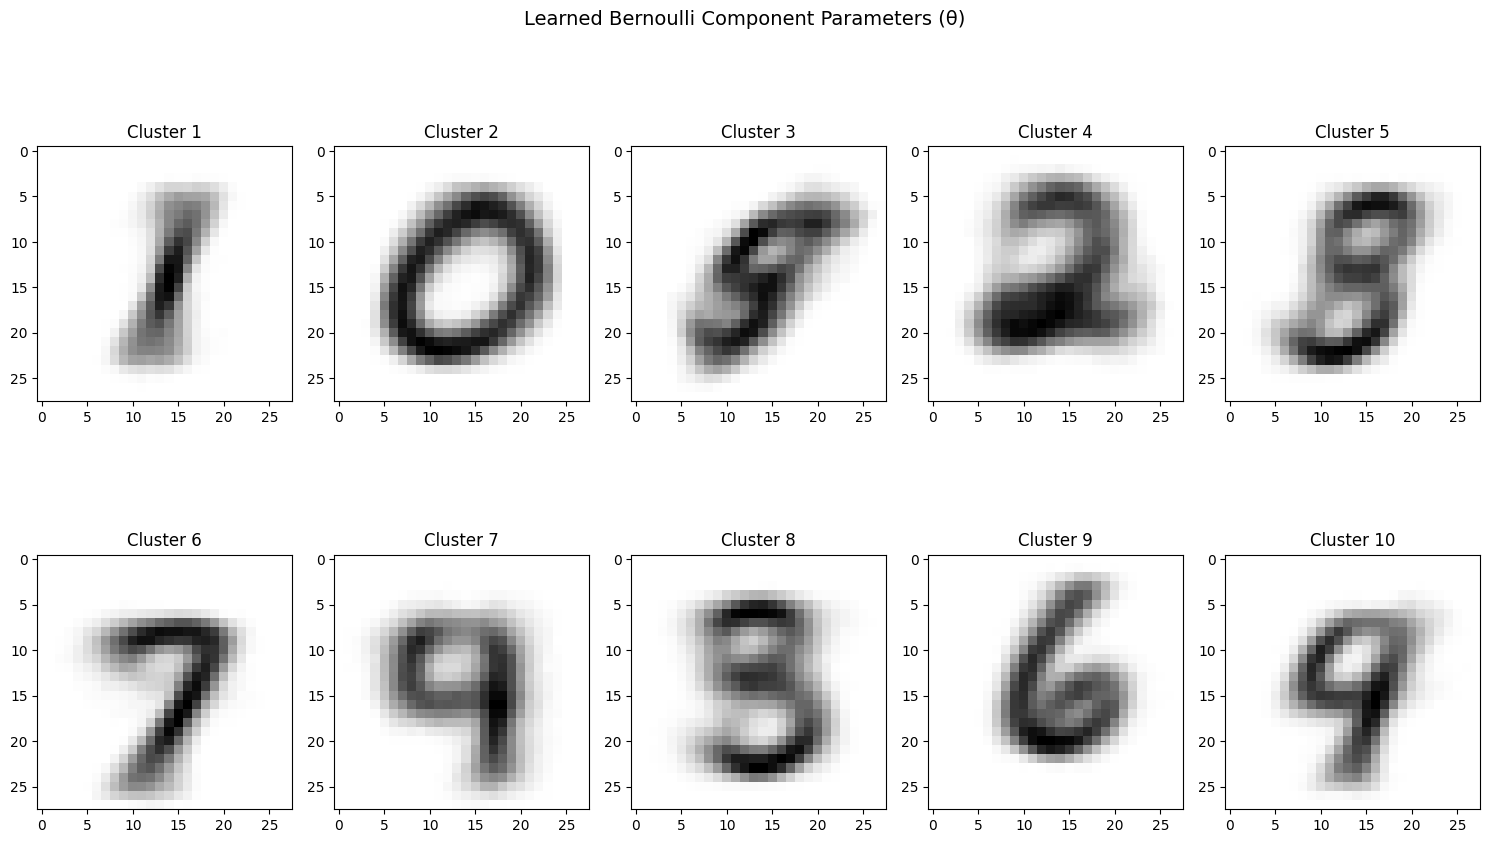

These probability maps show which pixels are likely 'on' for each component
They look like digit prototypes


In [5]:
# Plot component parameters (probability maps)
fig, axes = plot_clusters(em_model.components_params_, rows=2)
plt.suptitle('Learned Bernoulli Component Parameters (θ)', fontsize=14, y=1.02)
plt.savefig('../results/bernoulli_components.png', dpi=150, bbox_inches='tight')
plt.show()

print("These probability maps show which pixels are likely 'on' for each component")
print("They look like digit prototypes")

## 4. Soft Clustering: Analyze Responsibilities

Unlike K-means, EM provides probability distributions over clusters for each sample.

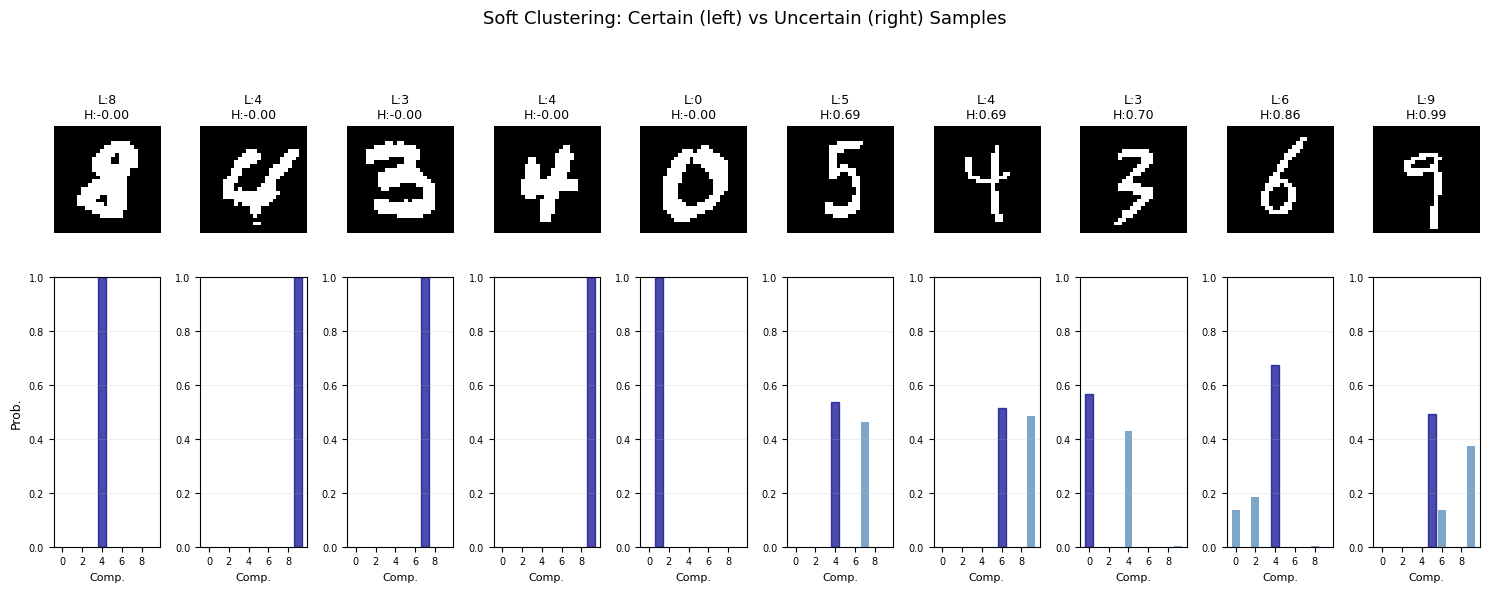

Left 5 columns: LOW entropy (certain) - one tall bar
Right 5 columns: HIGH entropy (uncertain) - multiple bars

Certain samples have entropy ≈ -0.000
Uncertain samples have entropy ≈ 0.786

L=true label, H=entropy (uncertainty measure)


In [12]:
# Get soft assignments for all training samples
all_train_probs = em_model.predict_proba(X_train)

# Calculate entropy to find samples with varying uncertainty
entropy_all = -np.sum(all_train_probs * np.log(all_train_probs + 1e-10), axis=1)

# Select samples: 5 certain (low entropy) + 5 uncertain (high entropy)
certain_idx = np.argsort(entropy_all)[:5]
uncertain_idx = np.argsort(entropy_all)[-5:]
selected_idx = np.concatenate([certain_idx, uncertain_idx])
sample_probs = all_train_probs[selected_idx]

# Visualize probability distributions
fig = plt.figure(figsize=(15, 6))

for i, idx in enumerate(selected_idx):
    # Show the digit (top row)
    ax_img = plt.subplot(2, 10, i+1)
    ax_img.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    label_text = f'L:{y_train[idx]}\nH:{entropy_all[idx]:.2f}'
    ax_img.set_title(label_text, fontsize=9)
    ax_img.axis('off')
    
    # Show probability distribution (bottom row)
    ax_bar = plt.subplot(2, 10, i+11)
    bars = ax_bar.bar(range(10), sample_probs[i], color='steelblue', alpha=0.7)
    # Highlight the dominant component
    max_idx = np.argmax(sample_probs[i])
    bars[max_idx].set_color('darkblue')
    ax_bar.set_ylim([0, 1])
    ax_bar.set_xticks(range(0, 10, 2))
    ax_bar.set_xlabel('Comp.', fontsize=8)
    ax_bar.tick_params(labelsize=7)
    if i == 0:
        ax_bar.set_ylabel('Prob.', fontsize=9)
    ax_bar.grid(axis='y', alpha=0.3, linewidth=0.5)

plt.suptitle('Soft Clustering: Certain (left) vs Uncertain (right) Samples', fontsize=13, y=0.98)
plt.tight_layout()
plt.savefig('../results/soft_assignments.png', dpi=150, bbox_inches='tight')
plt.show()

print("Left 5 columns: LOW entropy (certain) - one tall bar")
print("Right 5 columns: HIGH entropy (uncertain) - multiple bars")
print(f"\nCertain samples have entropy ≈ {entropy_all[certain_idx].mean():.3f}")
print(f"Uncertain samples have entropy ≈ {entropy_all[uncertain_idx].mean():.3f}")
print("\nL=true label, H=entropy (uncertainty measure)")

## 5. Identify Uncertain Samples

Samples with high entropy in their responsibility distribution are ambiguous.

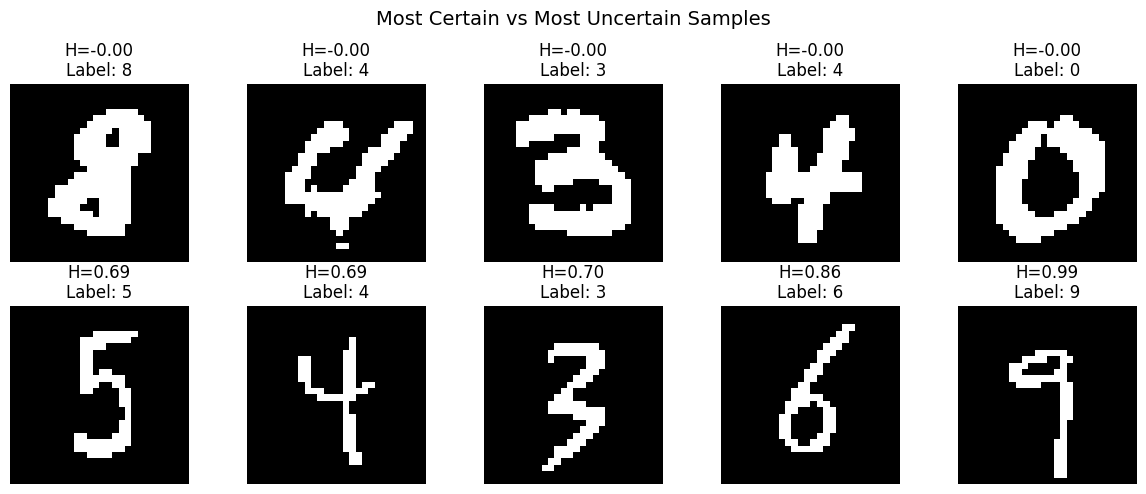

Mean entropy: 0.012
Entropy range: [-0.000, 0.988]

High entropy samples are often ambiguous or poorly written digits


In [7]:
# Calculate entropy for all training samples
all_probs = em_model.predict_proba(X_train)
entropy = -np.sum(all_probs * np.log(all_probs + 1e-10), axis=1)

# Find most certain and most uncertain samples
certain_indices = np.argsort(entropy)[:5]  # Lowest entropy
uncertain_indices = np.argsort(entropy)[-5:]  # Highest entropy

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Show certain samples
for col, idx in enumerate(certain_indices):
    axes[0, col].imshow(X_train[idx].reshape(28, 28), cmap='gray')
    axes[0, col].set_title(f'H={entropy[idx]:.2f}\nLabel: {y_train[idx]}')
    axes[0, col].axis('off')

# Show uncertain samples
for col, idx in enumerate(uncertain_indices):
    axes[1, col].imshow(X_train[idx].reshape(28, 28), cmap='gray')
    axes[1, col].set_title(f'H={entropy[idx]:.2f}\nLabel: {y_train[idx]}')
    axes[1, col].axis('off')

axes[0, 0].set_ylabel('Low Entropy\n(Certain)', fontsize=12)
axes[1, 0].set_ylabel('High Entropy\n(Uncertain)', fontsize=12)

plt.suptitle('Most Certain vs Most Uncertain Samples', fontsize=14)
plt.tight_layout()
plt.savefig('../results/uncertainty_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Mean entropy: {entropy.mean():.3f}")
print(f"Entropy range: [{entropy.min():.3f}, {entropy.max():.3f}]")
print("\nHigh entropy samples are often ambiguous or poorly written digits")

## 6. Compare with K-Means

Let's compare the learned components with K-means cluster centers.

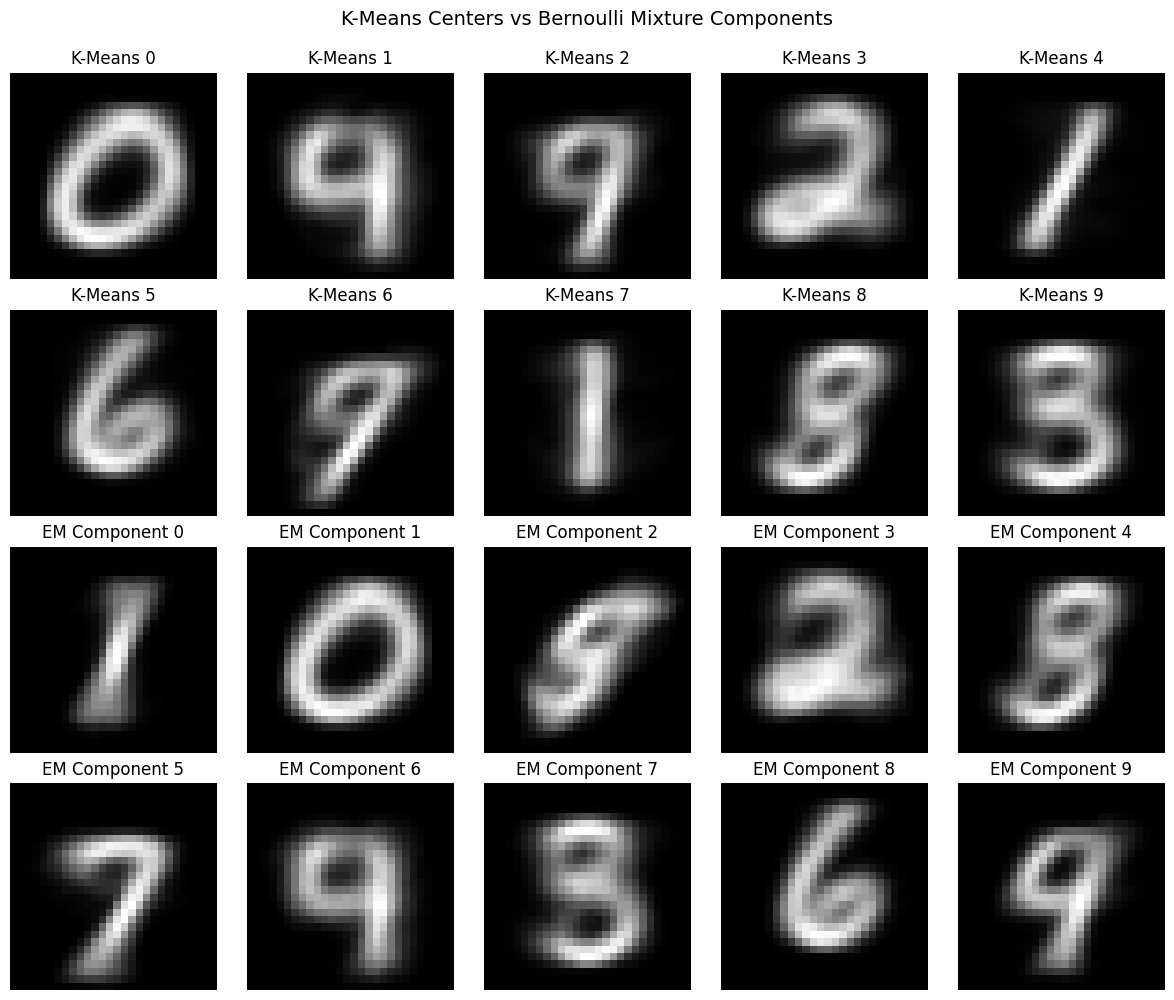

Both methods learn interpretable digit-like prototypes
But EM provides probabilistic assignments and uncertainty quantification


In [8]:
# Load grayscale data and fit K-means for comparison
from src.models.kmeans import KMeans

X_train_gray, _, _, _ = load_and_preprocess_mnist(n_samples=5000, binarize=False)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_train_gray)

# Plot side by side
fig = plt.figure(figsize=(12, 10))

# K-means centers
for i in range(10):
    ax = plt.subplot(4, 5, i+1)
    ax.imshow(kmeans.cluster_centers_[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'K-Means {i}')
    ax.axis('off')

# EM components
for i in range(10):
    ax = plt.subplot(4, 5, i+11)
    ax.imshow(em_model.components_params_[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'EM Component {i}')
    ax.axis('off')

plt.suptitle('K-Means Centers vs Bernoulli Mixture Components', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig('../results/kmeans_vs_em_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Both methods learn interpretable digit-like prototypes")
print("But EM provides probabilistic assignments and uncertainty quantification")

## 7. Test Set Evaluation

Apply the learned model to test data.

In [9]:
# Predict on test set
test_predictions = em_model.predict(X_test)
test_probs = em_model.predict_proba(X_test)

print(f"Predicted {len(test_predictions)} test samples")
print(f"\nTest set cluster distribution:")
unique, counts = np.unique(test_predictions, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({count/len(test_predictions)*100:.1f}%)")

# Test set uncertainty
test_entropy = -np.sum(test_probs * np.log(test_probs + 1e-10), axis=1)
print(f"\nTest set entropy statistics:")
print(f"  Mean: {test_entropy.mean():.3f}")
print(f"  Std: {test_entropy.std():.3f}")
print(f"  Range: [{test_entropy.min():.3f}, {test_entropy.max():.3f}]")

# Compare train vs test entropy
train_entropy = -np.sum(all_probs * np.log(all_probs + 1e-10), axis=1)
print(f"\nTrain mean entropy: {train_entropy.mean():.3f}")
print(f"Test mean entropy: {test_entropy.mean():.3f}")
print(f"Difference: {abs(test_entropy.mean() - train_entropy.mean()):.3f}")

Predicted 10000 test samples

Test set cluster distribution:
  Cluster 0: 1198 samples (12.0%)
  Cluster 1: 806 samples (8.1%)
  Cluster 2: 669 samples (6.7%)
  Cluster 3: 1062 samples (10.6%)
  Cluster 4: 1153 samples (11.5%)
  Cluster 5: 804 samples (8.0%)
  Cluster 6: 933 samples (9.3%)
  Cluster 7: 1440 samples (14.4%)
  Cluster 8: 751 samples (7.5%)
  Cluster 9: 1184 samples (11.8%)

Test set entropy statistics:
  Mean: 0.024
  Std: 0.107
  Range: [-0.000, 1.087]

Train mean entropy: 0.012
Test mean entropy: 0.024
Difference: 0.013


## 8. Calculate Clustering Purity

Evaluate cluster quality using ground truth labels.

In [13]:
def calculate_purity(labels_true, labels_pred):
    """Calculate clustering purity"""
    n_clusters = len(np.unique(labels_pred))
    n_samples = len(labels_true)
    
    purity_sum = 0
    for cluster in range(n_clusters):
        cluster_mask = labels_pred == cluster
        cluster_true_labels = labels_true[cluster_mask]
        
        if len(cluster_true_labels) > 0:
            most_common_count = np.bincount(cluster_true_labels).max()
            purity_sum += most_common_count
    
    return purity_sum / n_samples

train_purity = calculate_purity(y_train, em_model.labels_)
test_purity = calculate_purity(y_test, test_predictions)

print(f"Training Set Purity: {train_purity:.3f}")
print(f"Test Set Purity: {test_purity:.3f}")
print(f"\nComparison with K-means:")
print(f"K-Means (from notebook 02): ~0.50-0.70 (typical)")
print(f"Bernoulli Mixture: {train_purity:.3f}")
print(f"\nBoth methods capture digit structure reasonably well")

Training Set Purity: 0.611
Test Set Purity: 0.607

Comparison with K-means:
K-Means (from notebook 02): ~0.50-0.70 (typical)
Bernoulli Mixture: 0.611

Both methods capture digit structure reasonably well


## Summary

### Bernoulli Mixture Model via EM Algorithm:

**Advantages:**
- **Soft clustering**: Probability distributions over clusters
- **Uncertainty quantification**: Can identify ambiguous samples via entropy
- **Generative model**: Each component is a probability distribution
- **Interpretable**: Component parameters θ show pixel-level probabilities

**Considerations:**
- Requires binary data (binarization threshold choice matters)
- More computationally expensive than K-means
- Convergence depends on initialization
- More iterations needed than K-means

### Key Findings:

1. **Learned components look like digit prototypes** - The algorithm discovers interpretable structure
2. **Uncertainty correlates with ambiguity** - High entropy samples are genuinely difficult
3. **Performance comparable to K-means** - Similar purity scores
4. **Added value from soft assignments** - Richer information than hard clustering

### Comparison: K-Means vs Bernoulli Mixture

| Aspect | K-Means | Bernoulli Mixture |
|--------|---------|-------------------|
| Assignment | Hard (one cluster) | Soft (probability distribution) |
| Data type | Continuous | Binary |
| Distance | Euclidean | Log-likelihood |
| Uncertainty | Not available | Entropy of responsibilities |
| Speed | Fast | Moderate |
| Generative | No | Yes |

### Applications:

- Use **K-means** when speed matters and hard assignments suffice
- Use **Bernoulli mixture** when uncertainty quantification is needed or data is naturally binary